## Setup

Scroll down to [Experiments](#experiments).

In [88]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import wandb
import wandb.apis.public
import wandb.sdk
from scipy.optimize import curve_fit

In [69]:
api = wandb.Api()
runs: wandb.apis.public.Runs = api.runs(
    "ai2-llm/olmo-mup", filters={"group": "peteish1_v2", "display_name": {"$regex": r"^peteish1_v2_[^_]+_[^_]+$"}}
)
len(runs)

202

In [73]:
def get_model_size_and_lr(run_name: str) -> tuple[str, float]:
    WIDTH_TO_MODEL_SIZE = {
        512: "150M",
        2048: "1B",
    }

    match = re.match(r"peteish1_v2_([^_]+)_([^_]+)$", run_name)
    assert match is not None

    model_size = WIDTH_TO_MODEL_SIZE[int(match.group(1))]
    lr = float(match.group(2))
    return model_size, lr

In [72]:
FINAL_STEP = 10000
METRICS = [
    "train/CrossEntropyLoss",
    "eval/c4_en-validation/CrossEntropyLoss",
    "eval/downstream/hellaswag_len_norm",
    "eval/downstream/csqa_rc_5shot_len_norm",
    "eval/downstream/arc_easy_rc_5shot_acc",
    "eval/downstream/piqa_rc_5shot_len_norm",
]

In [74]:
metrics_by_model_size_and_lr: defaultdict[str, defaultdict[float, defaultdict[str, float]]] = defaultdict(
    lambda: defaultdict(lambda: defaultdict(float))
)

for run in runs:
    run: wandb.apis.public.Run

    if run.lastHistoryStep < FINAL_STEP or run.lastHistoryStep - run.historyLineCount > FINAL_STEP:
        continue

    history = list(run.scan_history(keys=METRICS, min_step=FINAL_STEP, max_step=FINAL_STEP + 1))

    # print(run.name, run.lastHistoryStep, list(history))
    if history:
        for metric in METRICS:
            if metric not in history[0]:
                continue

            model_size, lr = get_model_size_and_lr(run.name)
            metrics_by_model_size_and_lr[model_size][lr][metric] = history[0][metric]


In [119]:
%%capture
runs[1].group

In [121]:
%%capture
metrics_by_model_size_and_lr

## Experiments

### Do we get the same optimal LR for both 1B and a muP-scaled 150M?

We compare Peteish 1B and a 150M model created by scaling the 1B down to 150M using muP.
We want to find the optimal LR for both model sizes.

Goal: Optimal LR is identical for both sizes.

#### Config

- Tokens: 20B (10k steps)
- LR schedule: Cosine with initial LR $2^{-k}$ for various $k$.
- Warmup: 750 steps (1.5B tokens)
- Final LR: 10% of initial LR
- Sequence length: 2048, 1/2 of the usual 4096

Anneal of 1k steps (2k tokens) **pending**. Results below are pre-anneal.

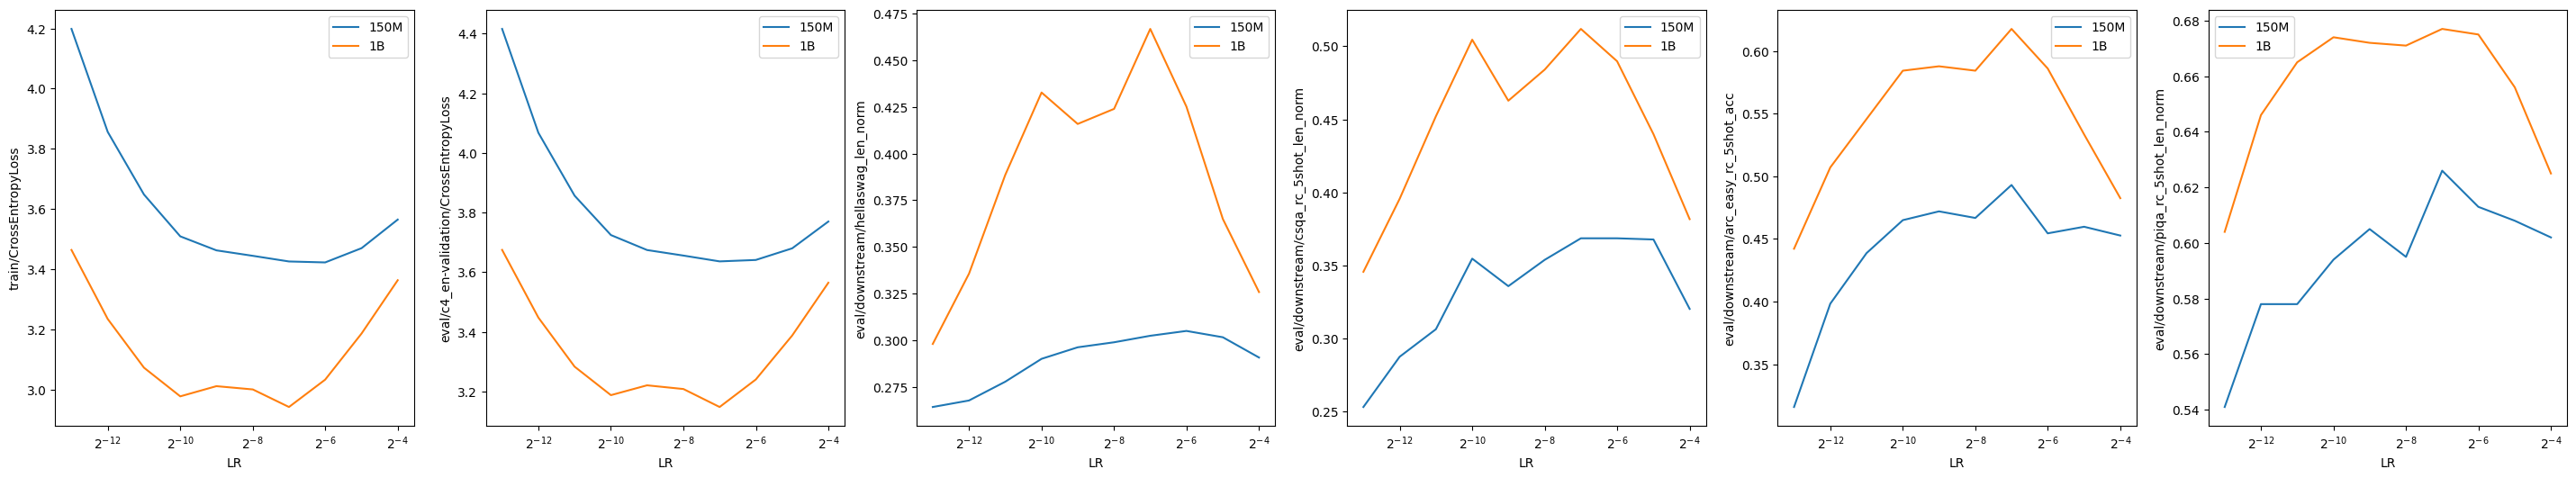

In [123]:
def curve(x, a, b, c):
    return a * x**2 + b * x + c

fig, axs = plt.subplots(ncols=len(METRICS), figsize=(6 * len(METRICS), 6))
for ax, metric in zip(axs, METRICS):
    for model_size in metrics_by_model_size_and_lr.keys():
        lrs = np.array(sorted(metrics_by_model_size_and_lr[model_size].keys()))
        metric_vals = np.array([metrics_by_model_size_and_lr[model_size][lr][metric] for lr in lrs])
        ax.plot(lrs, metric_vals, label=model_size)

        # popt, pcov = curve_fit(curve, np.log2(lrs), metric_vals)
        # y_fit = curve(np.log2(lrs), *popt)
        # ax.scatter(lrs, metric_vals, label=model_size)
        # ax.plot(lrs, y_fit)

    ax.set_xlabel('LR')  # Add an x-label to the Axes.
    ax.set_xscale('log', base=2)
    ax.set_ylabel(metric)  # Add a y-label to the Axes.
    ax.legend()

### Do we get the same optimal LR that matches for training of various lengths?

We compare our above 20B runs with 100B runs. We run at both 1B at 150M scale.

Goal: Optimal LR is identical for both run lengths.

#### Config

- Tokens: 100B (50k steps)
- LR schedule: Cosine with initial LR $2^{-k}$ for various $k$.
- Warmup: 1000 steps (2B tokens)
- Final LR: 10% of initial LR
- Sequence length: 2048, 1/2 of the usual 4096